In [29]:
import numpy as np
import pandas as pd
import catboost as cb
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, balanced_accuracy_score, roc_auc_score,
                             roc_curve, auc, log_loss)
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import seaborn as sns

import matplotlib.pyplot as plt

In [24]:
def train_catboost_model(X_train, y_train, X_test, y_test, cat_features=None,
                         iterations=1000, depth=9, learning_rate=0.005, l2_leaf_reg=0.01,
                         task_type="CPU", verbose=0):
    """
    Обучает модель CatBoost для данного таргета и возвращает её.

    Параметры:
      X_train: DataFrame или array-like, обучающие признаки.
      y_train: Series или array-like, целевая переменная.
      cat_features: список названий категориальных признаков.
      iterations, depth, learning_rate, task_type, verbose: параметры CatBoost.

    Возвращает:
      Обученную модель CatBoostClassifier.
    """
    if cat_features:
        model = cb.CatBoostClassifier(
            iterations=iterations,
            depth=depth,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            loss_function='Logloss',
            cat_features=cat_features,
            task_type=task_type,
            verbose=verbose
        )
    else:
        model = cb.CatBoostClassifier(
            iterations=iterations,
            depth=depth,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            loss_function='Logloss',
            task_type=task_type,
            verbose=verbose
        )
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    return model

In [5]:
train_mortgage = pd.read_csv('train_Mortgage.csv')
val_mortgage = pd.read_csv('val_Mortgage.csv')

train_pension = pd.read_csv('train_Pension.csv')
val_pension = pd.read_csv('val_Pension.csv')

train_savings = pd.read_csv('train_Savings.csv')
val_savings = pd.read_csv('val_Savings.csv')

train_data = [train_mortgage, train_pension, train_savings]
val_data = [val_mortgage, val_pension, val_savings]

In [34]:
def split_for_calibration(X_val, y_val, test_size=0.5, random_state=42):
    return train_test_split(X_val, y_val, test_size=test_size, random_state=random_state, stratify=y_val)


def calibrate_and_evaluate(model, X_calib, y_calib, X_test, y_test, method='sigmoid'):
    if method == 'sigmoid':
        calibrator = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
    elif method == 'isotonic':
        calibrator = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
    else:
        raise ValueError('Unknown calibration method')
    
    calibrator.fit(X_calib, y_calib)
    
    prob_test_uncalibrated = model.predict_proba(X_test)[:, 1]
    prob_test_calibrated = calibrator.predict_proba(X_test)[:, 1]

    auc_before = roc_auc_score(y_test, prob_test_uncalibrated)
    auc_after = roc_auc_score(y_test, prob_test_calibrated)

    logloss_before = log_loss(y_test, prob_test_uncalibrated)
    logloss_after = log_loss(y_test, prob_test_calibrated)

    print(f"AUC до калибровки: {auc_before:.4f}, после: {auc_after:.4f}")
    print(f"Logloss до калибровки: {logloss_before:.4f}, после: {logloss_after:.4f}")

    plt.figure(figsize=(8, 6))
    for label, probs in [('До калибровки', prob_test_uncalibrated), ('После калибровки', prob_test_calibrated)]:
        frac_pos, mean_pred = calibration_curve(y_test, probs, n_bins=10)
        plt.plot(mean_pred, frac_pos, label=label)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('Calibration Curves')
    plt.xlabel('Среднее предсказание вероятности')
    plt.ylabel('Доля положительных классов')
    plt.legend()
    plt.grid()
    plt.show()

    return calibrator

In [ ]:
def draw_probs_hist(clf_list, X_test, ncols=3):
    '''
    Отрисовка гистограмм предсказаний вероятностей.

    clf_list -- список кортежей (обученный классификатор, его название)
    X_test -- тестовая выборка
    ncols -- количество колонок для отрисовки графика
    '''
    with sns.axes_style('whitegrid'):
        nrows = int(np.ceil(len(clf_list) / ncols))
        plt.figure(figsize=(6 * ncols, 4 * nrows))

        for i, (clf, name) in enumerate(clf_list):
            plt.subplot(nrows, ncols, i + 1)
            y_prob = clf.predict_proba(X_test)[:, 1]
            plt.hist(y_prob, range=(0, 1), bins=10)
            plt.title(name)
            plt.xlabel('Предсказ. вероятность')
            plt.ylabel('Количество')
        
        plt.tight_layout()
        plt.show()


In [36]:
def draw_probs_hist(clf_list, X_test, ncols=3):
    '''
    Отрисовка гистограмм предсказаний вероятностей.

    clf_list -- список кортежей (обученный классификатор, его название)
    X_test -- тестовая выборка
    ncols -- количество колонок для отрисовки графика
    '''
    with sns.axes_style('whitegrid'):
        nrows = int(np.ceil(len(clf_list) / ncols))
        plt.figure(figsize=(6 * ncols, 4 * nrows))

        for i, (clf, name) in enumerate(clf_list):
            plt.subplot(nrows, ncols, i + 1)
            y_prob = clf.predict_proba(X_test)[:, 1]
            plt.hist(y_prob, range=(0, 1), bins=10)
            plt.title(name)
            plt.xlabel('Предсказ. вероятность')
            plt.ylabel('Количество')
        
        plt.tight_layout()
        plt.show()

====== Mortgage ====== 
Platt Scaling (Logistic Regression):
AUC до калибровки: 0.9461, после: 0.9461
Logloss до калибровки: 0.4057, после: 0.3209


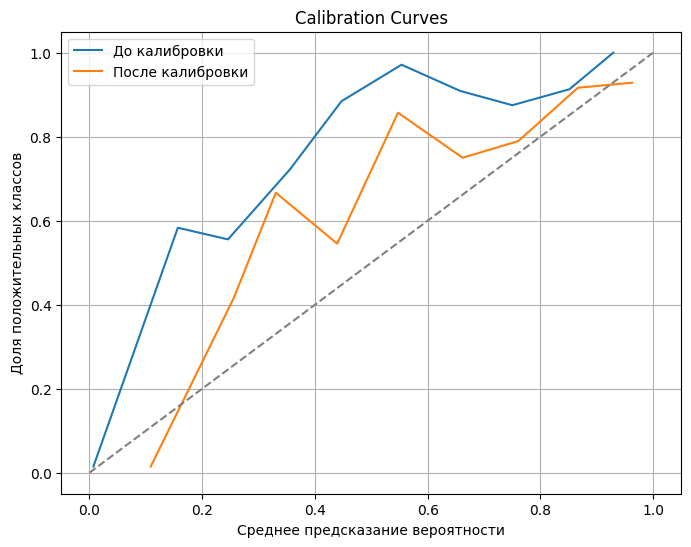

Isotonic Regression:
AUC до калибровки: 0.9461, после: 0.9439
Logloss до калибровки: 0.4057, после: 0.3456


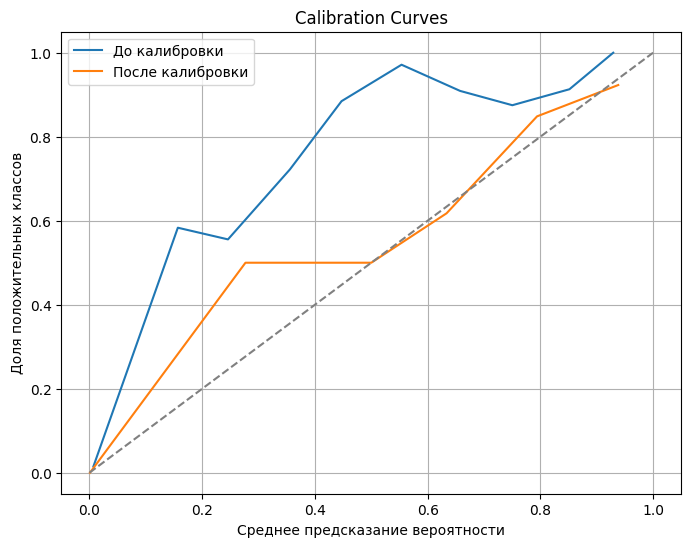

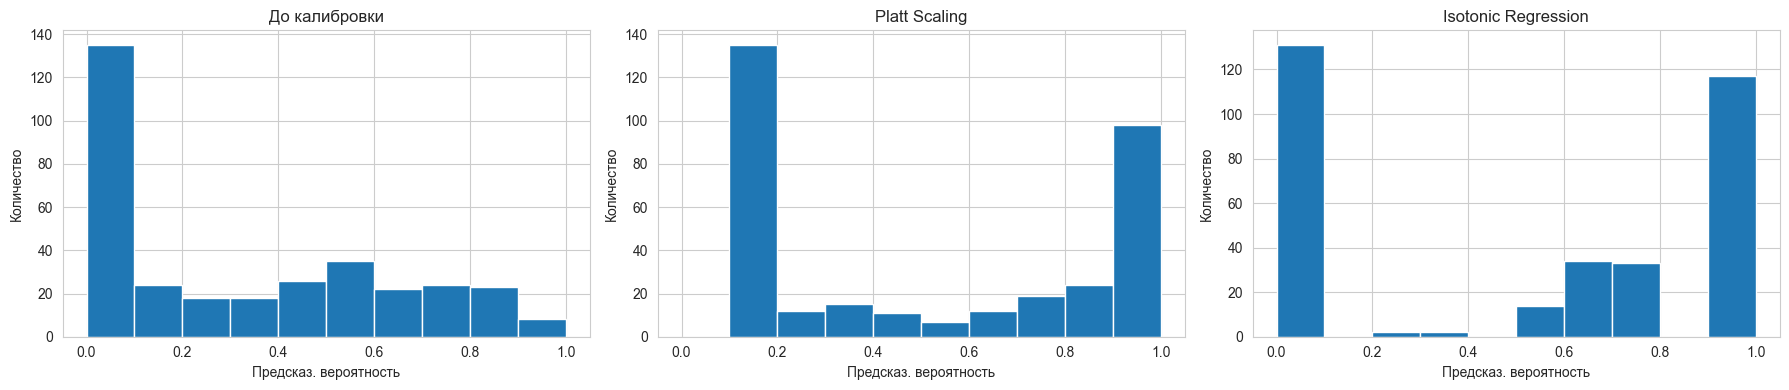

====== Pension ====== 
Platt Scaling (Logistic Regression):
AUC до калибровки: 0.8052, после: 0.8052
Logloss до калибровки: 0.6304, после: 0.5447


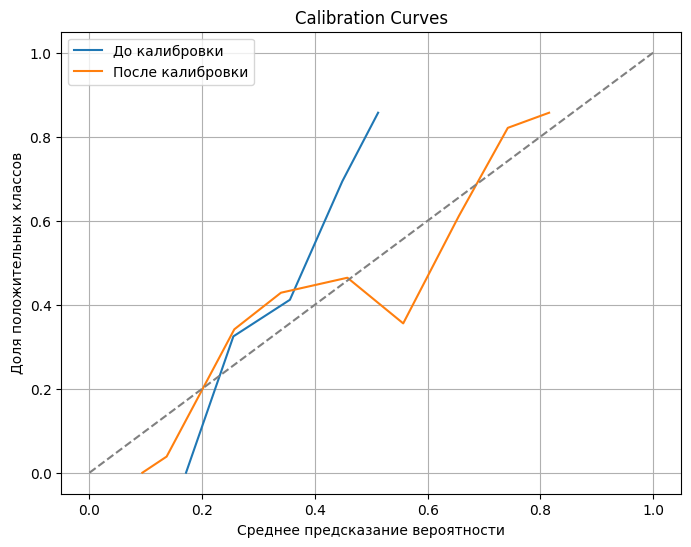

Isotonic Regression:
AUC до калибровки: 0.8052, после: 0.8051
Logloss до калибровки: 0.6304, после: 0.6577


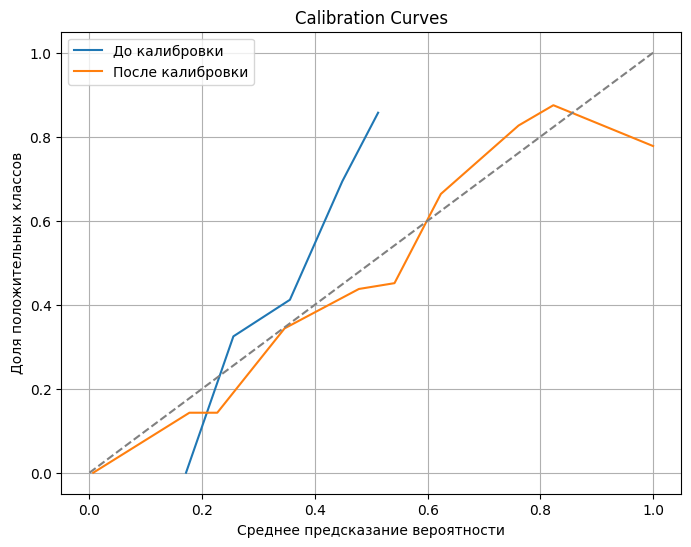

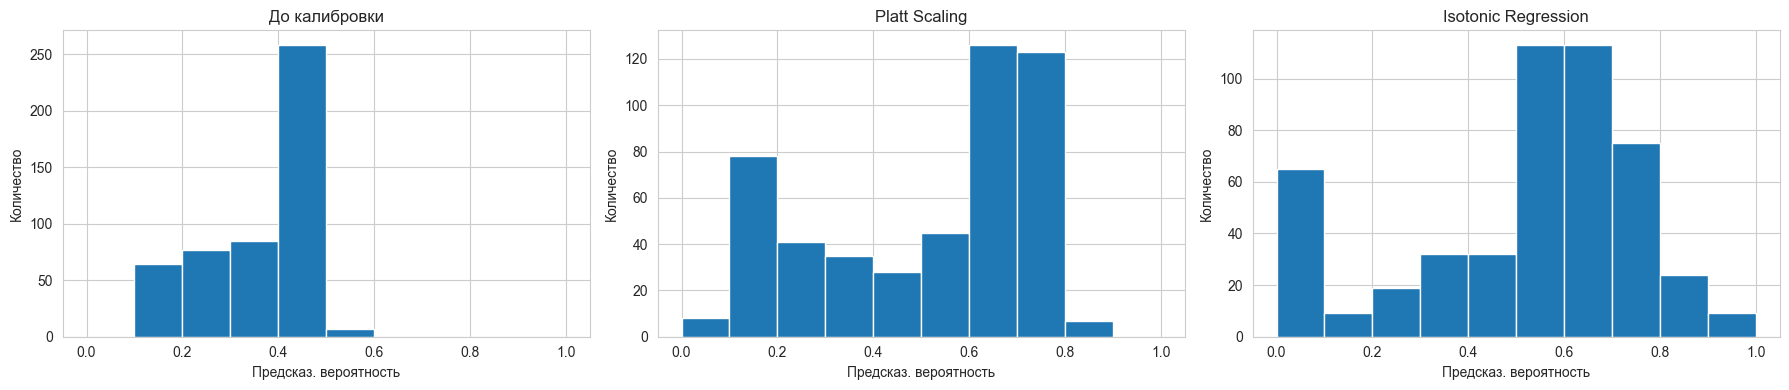

====== Savings ====== 
Platt Scaling (Logistic Regression):
AUC до калибровки: 0.6971, после: 0.6971
Logloss до калибровки: 0.6485, после: 0.6245


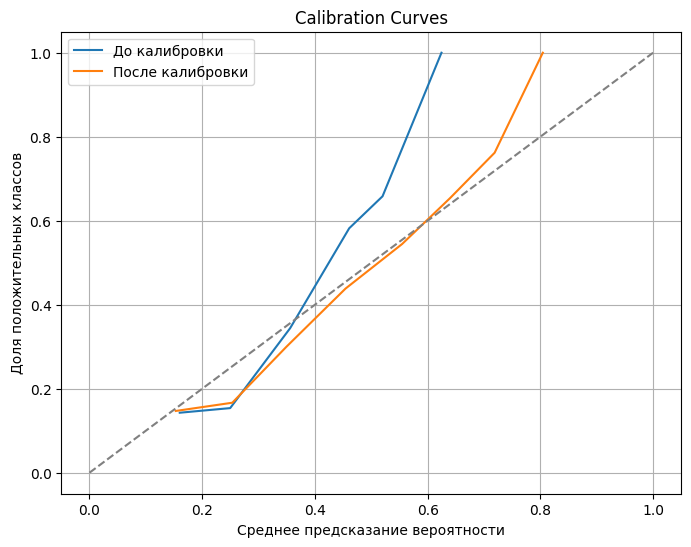

Isotonic Regression:
AUC до калибровки: 0.6971, после: 0.6937
Logloss до калибровки: 0.6485, после: 0.6262


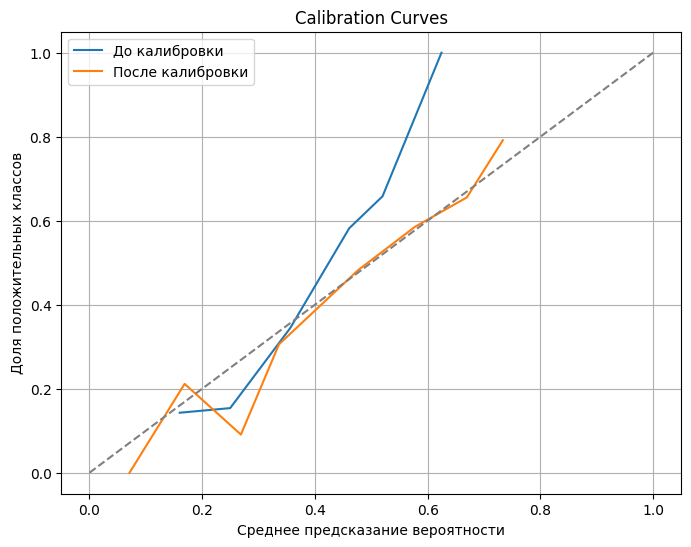

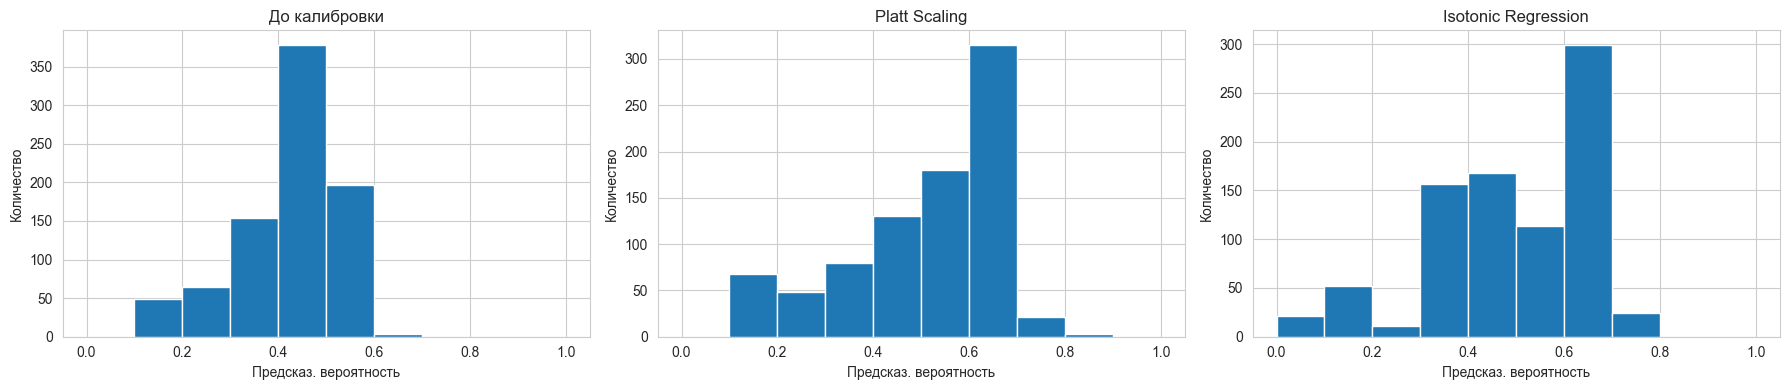

In [37]:
for train_df, val_df, name in zip(train_data, val_data, ['Mortgage', 'Pension', 'Savings']):
    print(f"====== {name} ====== ")

    X_train = train_df.drop(columns=[name])
    y_train = train_df[name]
    X_val = val_df.drop(columns=[name])
    y_val = val_df[name]

    X_calib, X_test, y_calib, y_test = split_for_calibration(X_val, y_val)

    model = train_catboost_model(X_train, y_train, X_test, y_test)

    print("Platt Scaling (Logistic Regression):")
    calibrator_sigmoid = calibrate_and_evaluate(model, X_calib, y_calib, X_test, y_test, method='sigmoid')

    print("Isotonic Regression:")
    calibrator_isotonic = calibrate_and_evaluate(model, X_calib, y_calib, X_test, y_test, method='isotonic')

    draw_probs_hist([
        (model, 'До калибровки'),
        (calibrator_sigmoid, 'Platt Scaling'),
        (calibrator_isotonic, 'Isotonic Regression')
    ], X_test)
